In [13]:
import warnings
warnings.filterwarnings('ignore')


In [14]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### DATA COLLECTION AND PRE-PROCESSING 

In [15]:
google_stock_data = pd.read_csv('GOOG.csv')
google_stock_data.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [16]:
google_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   float64
 13  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.7+ KB


In [17]:
google_stock_data = google_stock_data[['date','open','close']] # Extracting required columns
google_stock_data['date'] = pd.to_datetime(google_stock_data['date'].apply(lambda x: x.split()[0])) 
google_stock_data.set_index('date',drop=True,inplace=True) # Setting date column as index
google_stock_data.head()

,open,close
date,,
2016-06-14,716.48,718.27
2016-06-15,719.00,718.92
2016-06-16,714.91,710.36
2016-06-17,708.65,691.72
2016-06-20,698.77,693.71


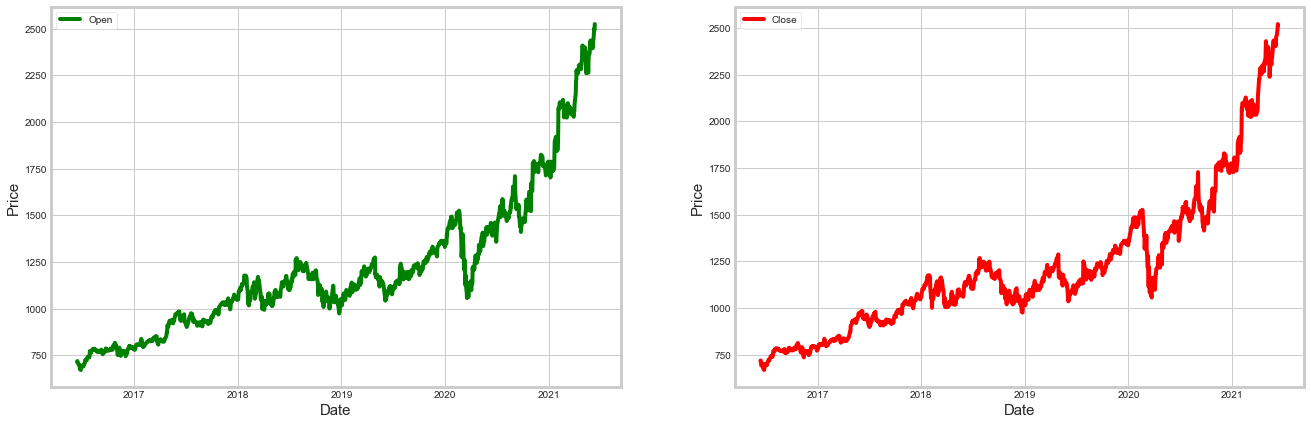

In [18]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(google_stock_data['open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()

ax[1].plot(google_stock_data['close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()

fg.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
google_stock_data[google_stock_data.columns] = MMS.fit_transform(google_stock_data)

In [20]:
google_stock_data.shape

(1258, 2)

In [21]:
training_size = round(len(google_stock_data) * 0.80) # Selecting 80 % for training and 20 % for testing
training_size

1006

In [22]:
train_data = google_stock_data[:training_size]
test_data  = google_stock_data[training_size:]

train_data.shape, test_data.shape

((1006, 2), (252, 2))

In [23]:
# Function to create sequence of data for training and testing

def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [24]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [25]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((956, 50, 2), (956, 2), (202, 50, 2), (202, 2))

### LSTM MODEL TRAINING

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [27]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10600     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30902 (120.71 KB)
Trainable params: 30902 (120.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
30/30 [==============================] - 8s 94ms/step - loss: 0.0059 - mean_absolute_error: 0.0545 - val_loss: 0.0084 - val_mean_absolute_error: 0.0761
Epoch 2/80
30/30 [==============================] - 2s 57ms/step - loss: 7.4021e-04 - mean_absolute_error: 0.0210 - val_loss: 0.0045 - val_mean_absolute_error: 0.0531
Epoch 3/80
30/30 [==============================] - 2s 51ms/step - loss: 4.9737e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0018 - val_mean_absolute_error: 0.0343
Epoch 4/80
30/30 [==============================] - 2s 54ms/step - loss: 4.7074e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0018 - val_mean_absolute_error: 0.0338
Epoch 5/80
30/30 [==============================] - 1s 47ms/step - loss: 4.2121e-04 - mean_absolute_error: 0.0145 - val_loss: 0.0019 - val_mean_absolute_error: 0.0341
Epoch 6/80
30/30 [==============================] - 2s 51ms/step - loss: 4.5539e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0029 - val_mean_absolute_error: 0.0434
Ep

Epoch 50/80
30/30 [==============================] - 2s 63ms/step - loss: 1.8424e-04 - mean_absolute_error: 0.0097 - val_loss: 0.0033 - val_mean_absolute_error: 0.0474
Epoch 51/80
30/30 [==============================] - 2s 68ms/step - loss: 1.8351e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0012 - val_mean_absolute_error: 0.0268
Epoch 52/80
30/30 [==============================] - 2s 67ms/step - loss: 1.8265e-04 - mean_absolute_error: 0.0099 - val_loss: 0.0025 - val_mean_absolute_error: 0.0399
Epoch 53/80
30/30 [==============================] - 2s 69ms/step - loss: 1.7207e-04 - mean_absolute_error: 0.0097 - val_loss: 0.0038 - val_mean_absolute_error: 0.0505
Epoch 54/80
30/30 [==============================] - 2s 69ms/step - loss: 2.0241e-04 - mean_absolute_error: 0.0104 - val_loss: 0.0014 - val_mean_absolute_error: 0.0298
Epoch 55/80
30/30 [==============================] - 2s 65ms/step - loss: 1.8101e-04 - mean_absolute_error: 0.0098 - val_loss: 0.0025 - val_mean_absolute_error:

In [29]:
test_predicted = model.predict(test_seq)
test_predicted[:5]

7/7 [==============================] - 1s 20ms/step


array([[0.49308127, 0.49700388],
       [0.49868745, 0.5025853 ],
       [0.5050317 , 0.50884014],
       [0.52324504, 0.5267545 ],
       [0.5313198 , 0.53508043]], dtype=float32)

In [32]:
test_inverse_predicted = MMS.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[1585.1332, 1589.3772],
       [1595.5266, 1599.7214],
       [1607.2883, 1611.3138],
       [1641.0544, 1644.5153],
       [1656.0244, 1659.946 ]], dtype=float32)

### DATA VISUALIZATION

In [33]:
gs_slic_data = pd.concat([google_stock_data.iloc[-202:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=google_stock_data.iloc[-202:].index)], axis=1)

In [34]:
gs_slic_data[['open','close']] = MMS.inverse_transform(gs_slic_data[['open','close']])

In [35]:
gs_slic_data.head()

,open,close,open_predicted,close_predicted
date,,,,
2020-08-24,1593.98,1588.20,1585.133179,1589.377197
2020-08-25,1582.07,1608.22,1595.526611,1599.721436
2020-08-26,1608.00,1652.38,1607.288330,1611.313843
2020-08-27,1653.68,1634.33,1641.054443,1644.515259
2020-08-28,1633.49,1644.41,1656.024414,1659.946045


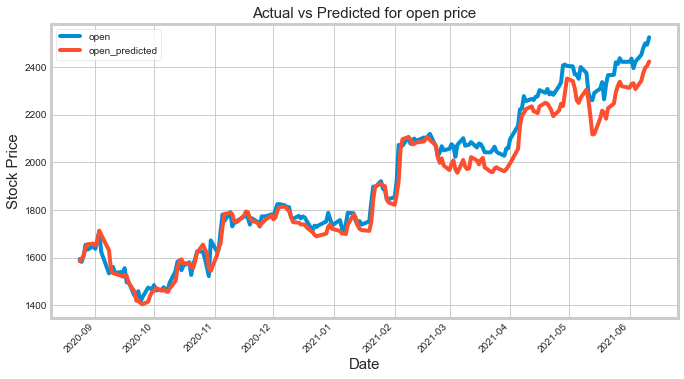

In [36]:
gs_slic_data[['open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

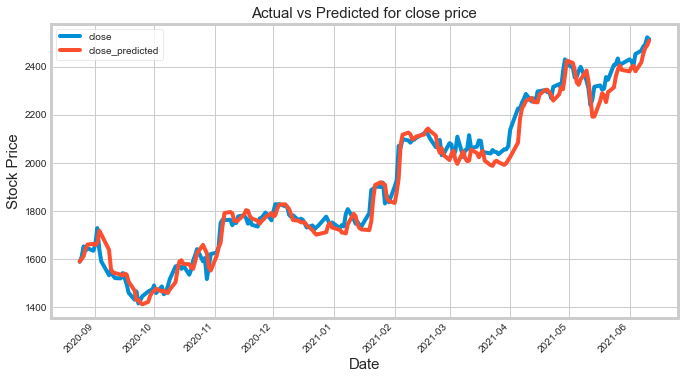

In [37]:
gs_slic_data[['close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

### PREDICTING FOR UPCOMING 10 DAYS

In [38]:
gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))

In [39]:
gs_slic_data['2021-06-09	':'2021-06-16']

,open,close,open_predicted,close_predicted
2021-06-09,2499.5,2491.4,2396.385254,2476.83252
2021-06-10,2494.01,2521.6,2404.930176,2487.652832
2021-06-11,2524.92,2513.93,2423.102051,2507.96582
2021-06-12,NaN,NaN,NaN,NaN
2021-06-13,NaN,NaN,NaN,NaN
2021-06-14,NaN,NaN,NaN,NaN
2021-06-15,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN


In [40]:
upcoming_prediction = pd.DataFrame(columns=['open','close'],index=gs_slic_data.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [41]:
curr_seq = test_seq[-1:]

for i in range(-10,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)

1/1 [==============================] - 0s 35ms/step


In [42]:
upcoming_prediction[['open','close']] = MMS.inverse_transform(upcoming_prediction[['open','close']])

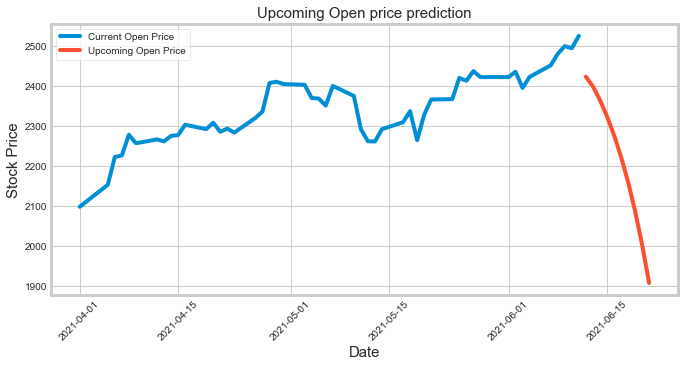

In [43]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'open'],label='Current Open Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'open'],label='Upcoming Open Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming Open price prediction',size=15)
ax.legend()
fg.show()

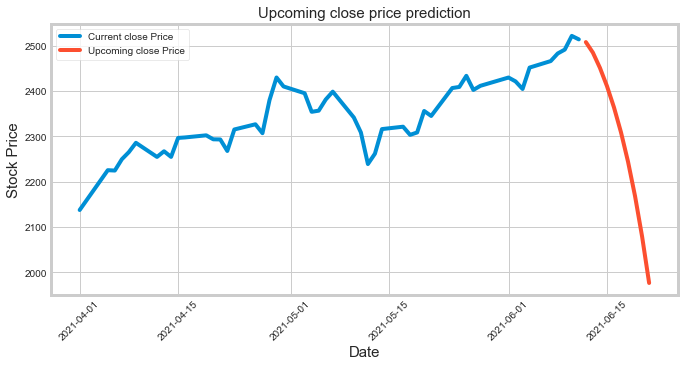

In [44]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2021-04-01':,'close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2021-04-01':,'close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fg.show()